**FCN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

## Build FCN Model and display summary

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train,  prep_coco_dataset
from mrcnn.coco            import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

## Notebook Preferences

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# def get_ax(rows=1, cols=1, size=16):
#     """Return a Matplotlib Axes array to be used in
#     all visualizations in the notebook. Provide a
#     central point to control graph sizes.
    
#     Adjust the size attribute to control how big to render images
#     """
#     _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
#     return ax


## Configurations

DIR_TRAINING = os.path.expanduser('/home/kbardool/models/')
FCN_TRAINING_PATH   = os.path.join(DIR_TRAINING  , "train_fcn_coco")
print(FCN_TRAINING_PATH)
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.NAME                 = 'fcn'              
fcn_config.BATCH_SIZE           = 1                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = 1               # Must match BATCH_SIZE
# fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.FCN_INPUT_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 
# fcn_config.FCN_VGG16_MODEL_PATH = mrcnn_config.FCN_VGG16_MODEL_PATH
fcn_config.TRAINING_PATH        = FCN_TRAINING_PATH
fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4
 
fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.EPOCHS_TO_RUN        = 2
fcn_config.LEARNING_RATE        = 0.01 
fcn_config.LAST_EPOCH_RAN       = 0
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'
fcn_config.display()

## Build FCN Model

with tf.device(DEVICE):
    ##------------------------------------------------------------------------------------
    ## Build FCN Model in Training Mode
    ##------------------------------------------------------------------------------------
    try :
        del fcn_model
        gc.collect()
    except: 
        pass    
#   fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)
    fcn_model = fcn_modellib.FCN(mode="inference", arch='FCN8', config=fcn_config)

fcn_model.keras_model.summary()

Using TensorFlow backend.


/home/kbardool/models/train_fcn_coco

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SI

## Set weight files

In [9]:
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181020T1506/fcn_0124.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5'
# weights_path= 'F:/models/train_fcn_coco/fcn20181021T1602/fcn_0188.h5'
# weights_path= '/home/kbardool/models/train_fcn_coco/fcn20181022T1622/fcn_0001.h5'

# DIR_WEIGHTS = '/home/kbardool/models/train_fcn_coco/fcn20181023T0825'
# DIR_WEIGHTS = '/home/kbardool/models/train_fcn8_coco/fcn20181026T1432'

# filepath = os.path.join(DIR_WEIGHTS, 'fcn_init_weights')
# fcn_model.keras_model.save_weights(filepath, overwrite=True)
# fcn_model.save_model(DIR_WEIGHTS, 'fcn_init_weights')
# fcn_model.keras_model.summary()
##'fcn_init_weights.h5',
# DIR_WEIGHTS =  'F:/models/train_fcn8_coco/fcn20181031T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization

# DIR_WEIGHTS = '/home/kbardool/models/train_fcn8_coco/fcn20181028T1324' ### Training with LR=0.0001, MSE Loss
# DIR_WEIGHTS = '/home/kbardool/models/train_fcn8_coco/fcn20181030T0000' ### Training with LR=0.0001, MSE Loss NO L2 Regularization
# DIR_WEIGHTS =  '/home/kbardool/models/train_fcn8_coco/fcn20181031T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
DIR_WEIGHTS =  '/users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
# files = ['fcn_0001.h5','fcn_0027.h5','fcn_0036.h5','fcn_0051.h5','fcn_0076.h5','fcn_0106.h5','fcn_0156.h5']
files   = ['fcn_0448.h5','fcn_0492.h5','fcn_0623.h5','fcn_0624.h5','fcn_0628.h5','fcn_0665.h5','fcn_0699.h5']

## Load Weights - 1

In [13]:
weights_path = os.path.join(DIR_WEIGHTS  , files[0])
fcn_model.load_model_weights(weights_path)

Loading weights  /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0448.h5
-----------------------------------------------
 Load Model with init parm: [ /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0448.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0448.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0448.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 1st weight file

In [14]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[0]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1060613394,+0.0974069163,+0.0397307165
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0523373187,+0.0133150285,+0.0157666784
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1032660231,+0.0986804739,+0.0424404629
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0368375517,+0.0037660170,+0.0092437482
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0962981060,+0.0862577409,+0.0347778127
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0331016816,+0.0159988813,+0.0106104715
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0903620049,+0.0922562480,+0.0302442722
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0285103396,+0.0136347711,+0.0083632534
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0849077925,+0.0884060413,+0.0249464177
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0301020332,+0.0231781397,+0.0093555832


### Histograms of Weights - 1st weight file

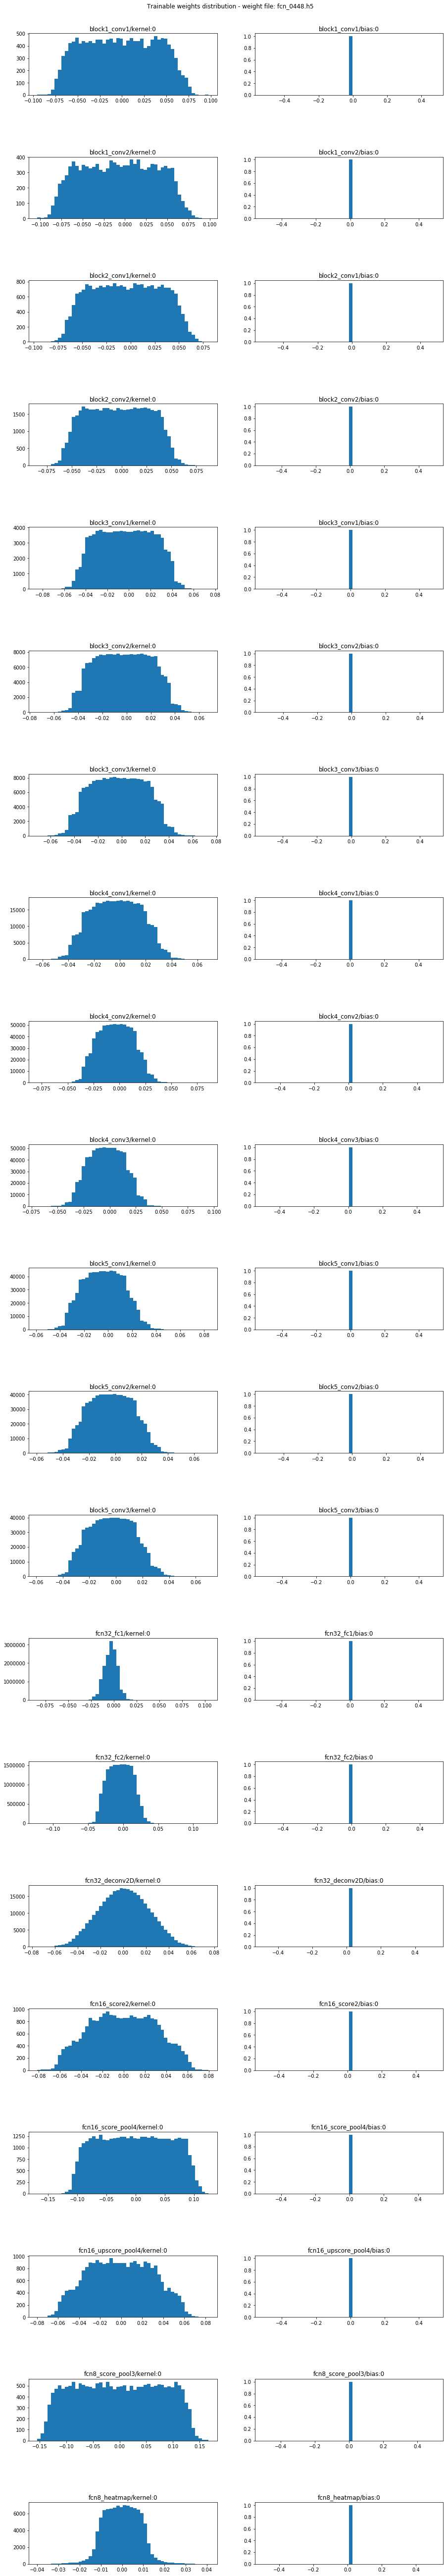

In [15]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = files[0])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[0]+'.png')
a.savefig(weights_histogram)

## Load Weights - 2

In [16]:
weights_path = os.path.join(DIR_WEIGHTS  , files[1])
fcn_model.load_model_weights(weights_path)

-----------------------------------------------
 Load Model with init parm: [ /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0492.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0492.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0492.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 2nd weights file

In [18]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1060611978,+0.0974021927,+0.0397306643
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0523441248,+0.0133166220,+0.0157678537
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1032659933,+0.0986767039,+0.0424404107
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0368450657,+0.0037649446,+0.0092446702
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0962981060,+0.0862490684,+0.0347778164
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0331007726,+0.0160021856,+0.0106104072
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0903621763,+0.0922646895,+0.0302442703
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0285103396,+0.0136349872,+0.0083625130
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0849079937,+0.0884094834,+0.0249464121
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0301019941,+0.0231771357,+0.0093550365


### Histograms of Weights - 2nd weights file

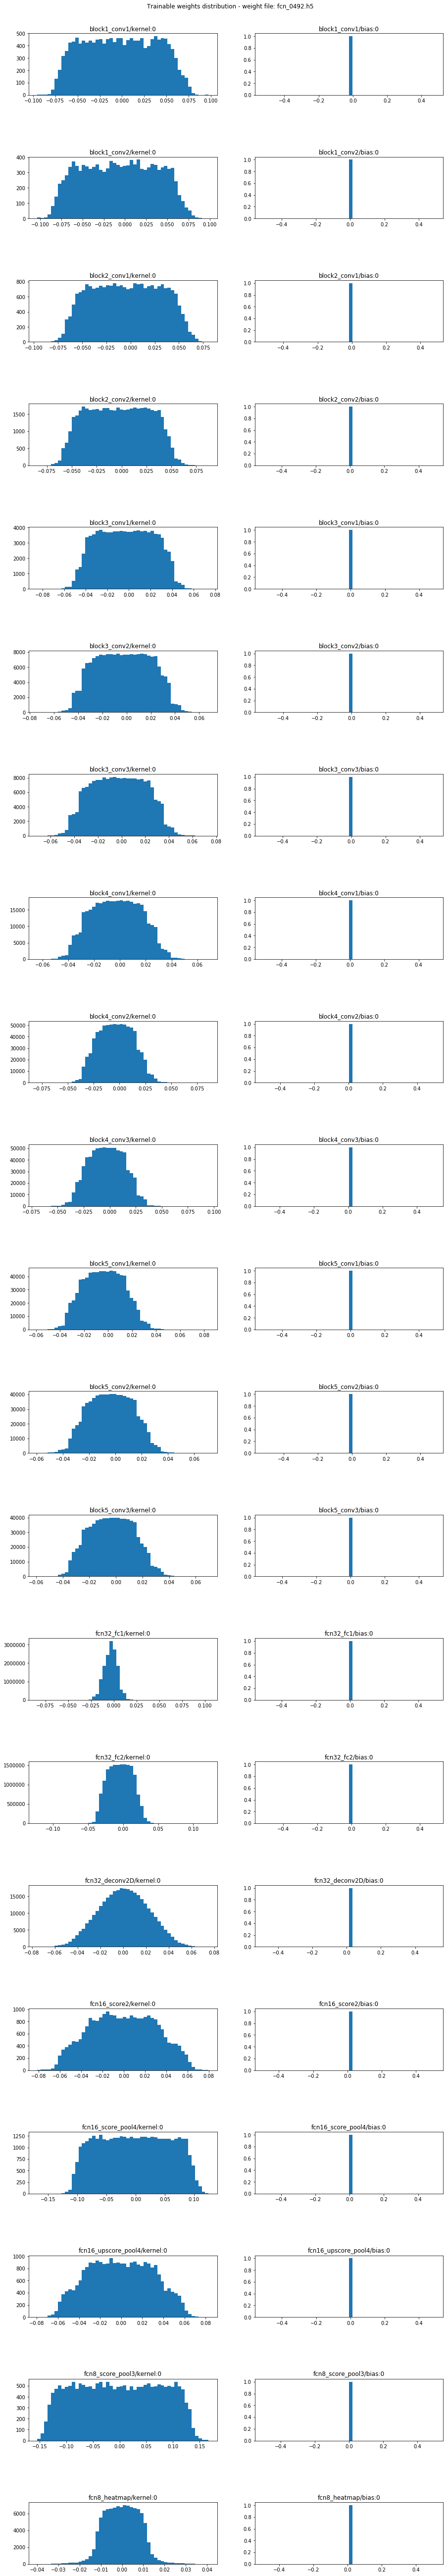

In [19]:
a = visualize.display_weight_histograms(fcn_model, filename = files[1])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[1]+'.png')
a.savefig(weights_histogram)

## Load Weights - 3rd weight file

### load

In [20]:
weights_path = os.path.join(DIR_WEIGHTS  , files[2])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0623.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0623.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0623.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 3rd weight file

In [21]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1060099304,+0.0975227505,+0.0397304296
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0519839823,+0.0132924858,+0.0157960132
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1032653749,+0.0987138823,+0.0424404778
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0369750783,+0.0037930820,+0.0092559457
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0962980315,+0.0861869976,+0.0347781889
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0331014171,+0.0160394702,+0.0106049469
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0903631896,+0.0923697725,+0.0302444026
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0285101533,+0.0136098573,+0.0083528310
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0849121511,+0.0884306729,+0.0249463562
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0301018562,+0.0231480617,+0.0093590338


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.1060099304</td><td>+0.0975227505</td><td>+0.0397304296</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0519839823</td><td>+0.0132924858</td><td>+0.0157960132</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.1032653749</td><td>+0.0987138823</td><td>+0.0424404778</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0369750783</td><td>+0.0037930820</td><td>+0.0092559457</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.0962980315</td><td>+0.0861869976</td><td>+0.0347781889</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 3rd weight file

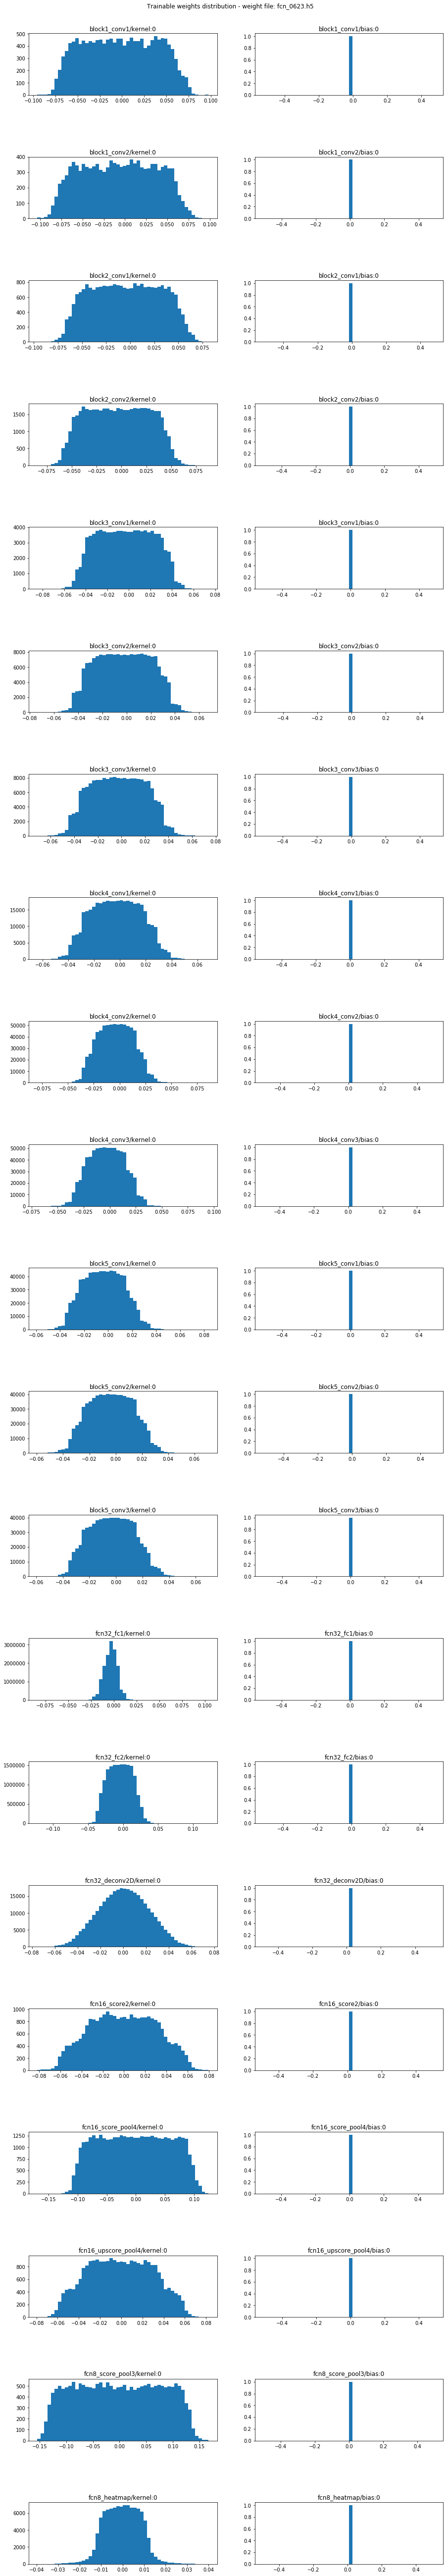

In [22]:
a = visualize.display_weight_histograms(fcn_model, filename = files[2])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[2]+'.png')
a.savefig(weights_histogram)

## Load Weights - 4rd weight file

In [25]:
weights_path = os.path.join(DIR_WEIGHTS  , files[3])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0624.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0624.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0624.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 4th weight file

In [26]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1059971303,+0.0975608006,+0.0397304259
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0518695526,+0.0132673178,+0.0158016086
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1032654345,+0.0987760872,+0.0424408019
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0370898545,+0.0038347519,+0.0092736101
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0962980688,+0.0861309096,+0.0347784199
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0331284739,+0.0160588715,+0.0106002847
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0903653353,+0.0924273357,+0.0302444324
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0285101533,+0.0135938544,+0.0083515504
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0849143937,+0.0884416401,+0.0249463376
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0301018562,+0.0231305473,+0.0093614450


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.1059971303</td><td>+0.0975608006</td><td>+0.0397304259</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0518695526</td><td>+0.0132673178</td><td>+0.0158016086</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.1032654345</td><td>+0.0987760872</td><td>+0.0424408019</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0370898545</td><td>+0.0038347519</td><td>+0.0092736101</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.0962980688</td><td>+0.0861309096</td><td>+0.0347784199</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights

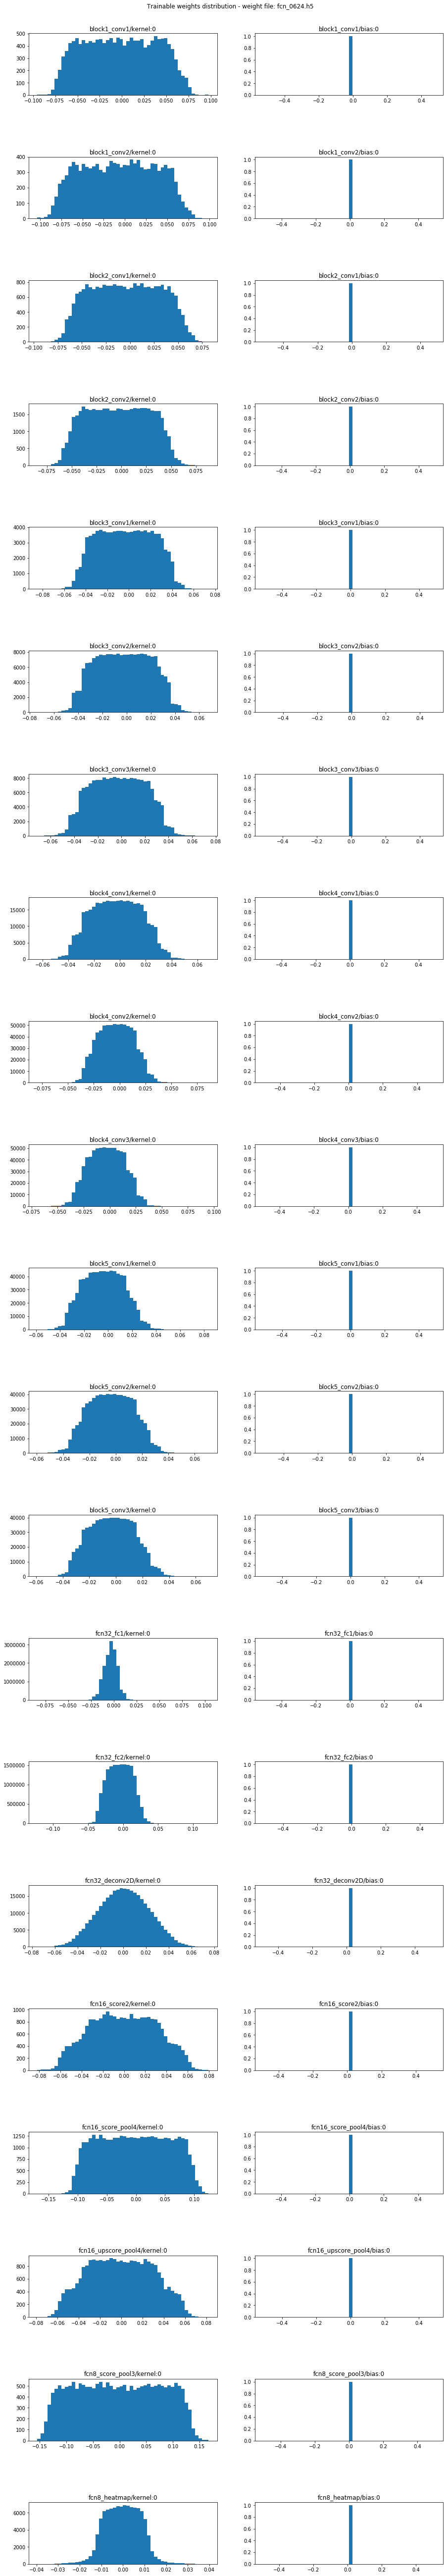

In [27]:
a = visualize.display_weight_histograms(fcn_model, filename = files[3])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[3]+'.png')
a.savefig(weights_histogram)

## Load Weights - 5th weight file

In [28]:
weights_path = os.path.join(DIR_WEIGHTS  , files[4])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0628.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0628.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0628.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 5th weight file

In [29]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1059819311,+0.0976189002,+0.0397303440
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0518056341,+0.0132652959,+0.0158189088
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1032655388,+0.0987817943,+0.0424405038
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0371953510,+0.0038391571,+0.0092812907
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0962981358,+0.0860778838,+0.0347784497
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0331777036,+0.0160625018,+0.0106066298
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0903679654,+0.0924689397,+0.0302444212
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0285101533,+0.0135965729,+0.0083530508
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0849169493,+0.0884436518,+0.0249462575
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0301057547,+0.0231320765,+0.0093626082


### Histograms of Weights - 5th weight file

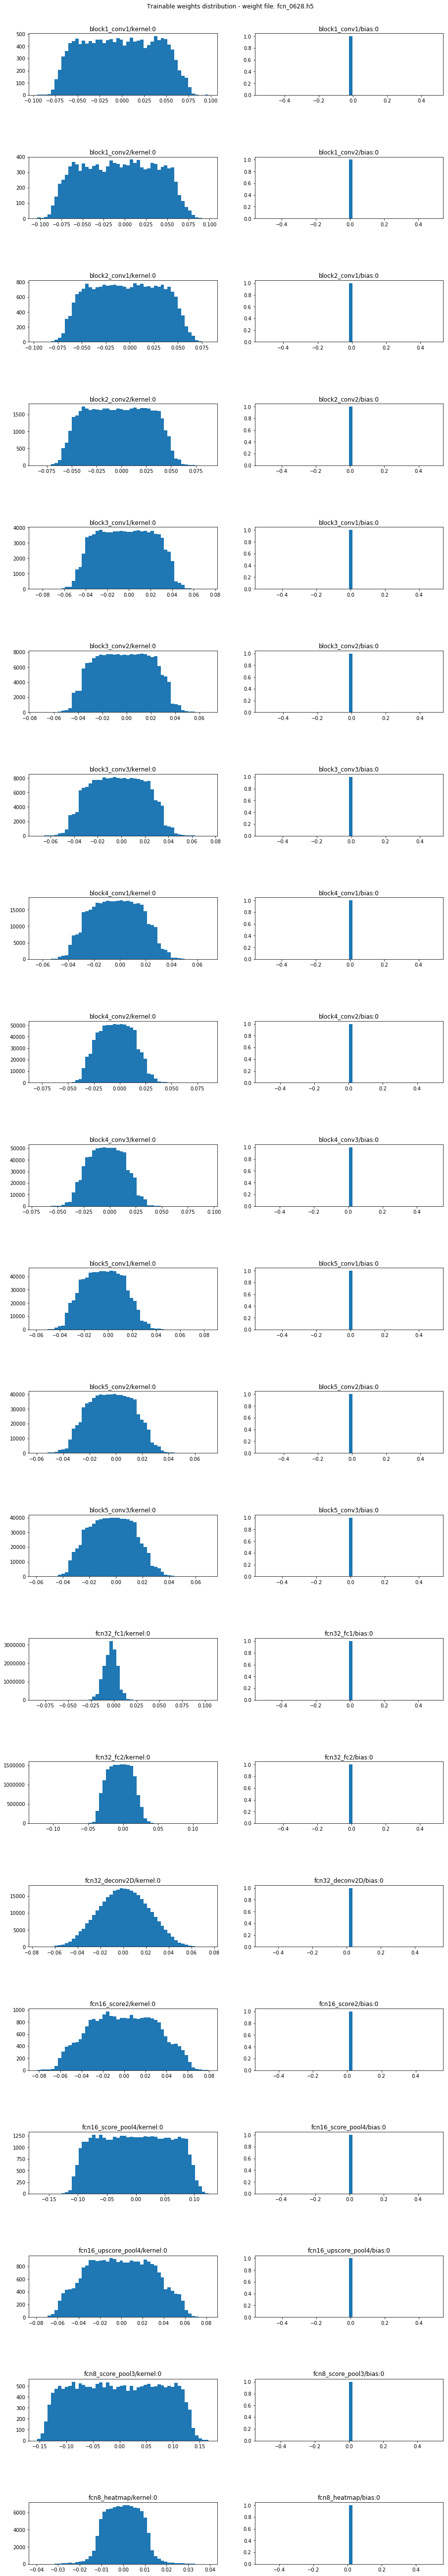

In [30]:
a = visualize.display_weight_histograms(fcn_model, filename = files[4])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[4]+'.png')
a.savefig(weights_histogram)

## Load Weights - 6th weight file

In [31]:
weights_path = os.path.join(DIR_WEIGHTS  , files[5])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0665.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0665.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0665.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 6th weight file

In [32]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1059582978,+0.0976629108,+0.0397302844
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0518000573,+0.0132598961,+0.0158366859
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1032655835,+0.0987853855,+0.0424402133
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0372597799,+0.0038466321,+0.0092892814
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0962981582,+0.0860540643,+0.0347785503
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0332118794,+0.0160661619,+0.0106102470
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0903750211,+0.0925139487,+0.0302444398
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0285101533,+0.0135968523,+0.0083527146
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0849195644,+0.0884391889,+0.0249461848
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0301123708,+0.0231317189,+0.0093643237


### Histograms of Weights - 6th weight file

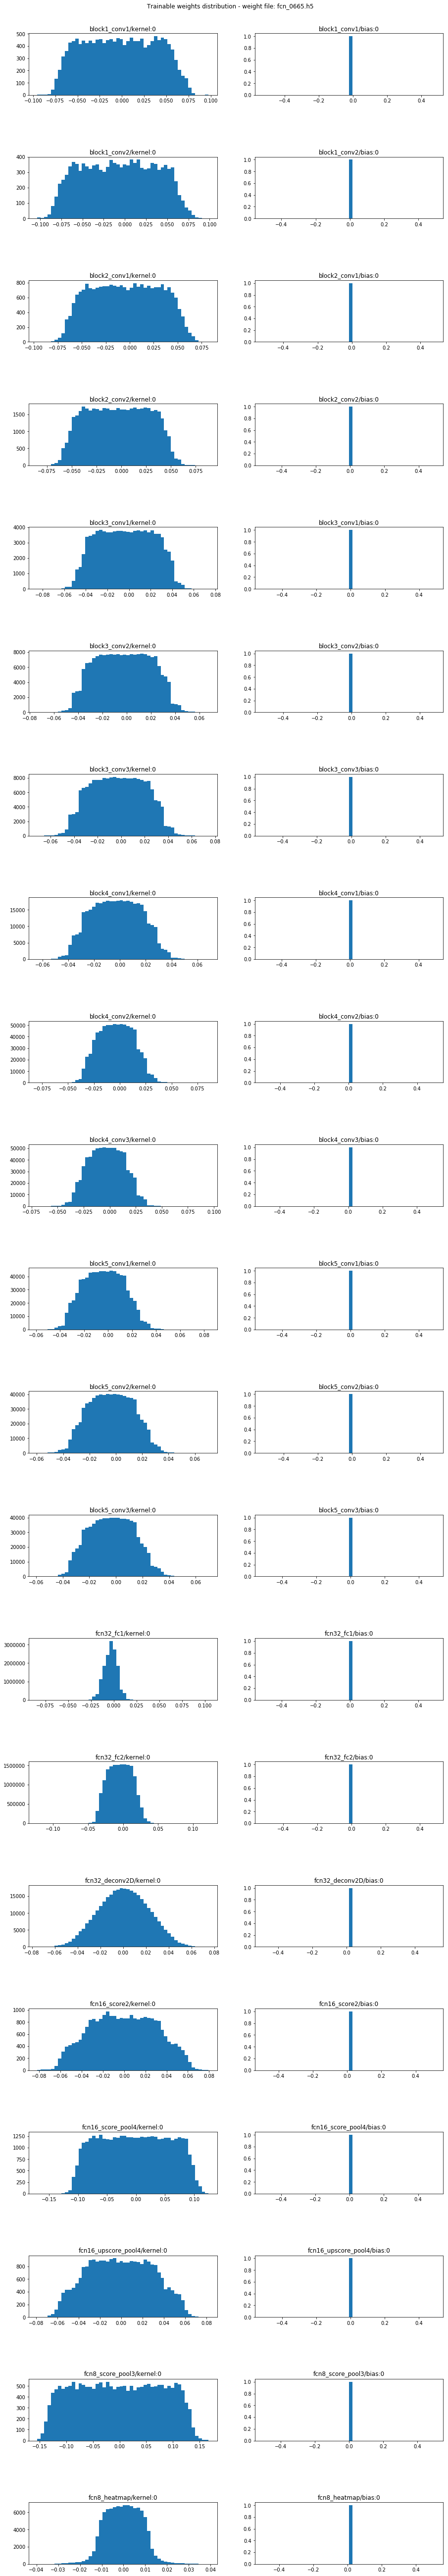

In [33]:
a = visualize.display_weight_histograms(fcn_model, filename = files[5])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[5]+'.png')
a.savefig(weights_histogram)

## Load Weights - 7th weight file

In [34]:
weights_path = os.path.join(DIR_WEIGHTS  , files[6])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0699.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0699.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /users/students/r0653928/models/train_fcn8_coco/fcn20181031T0000/fcn_0699.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 7th weight file

In [35]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1059534252,+0.0976684541,+0.0397302769
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0517979078,+0.0132586621,+0.0158389863
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1032656059,+0.0987859666,+0.0424401760
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0372713841,+0.0038481660,+0.0092906151
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0962981582,+0.0860494375,+0.0347785726
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0332172252,+0.0160667934,+0.0106107304
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0903755650,+0.0925210416,+0.0302444417
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0285101533,+0.0135970684,+0.0083526066
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0849195719,+0.0884390920,+0.0249461737
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0301133916,+0.0231320411,+0.0093645770


### Histograms of Weights - 7th weight file

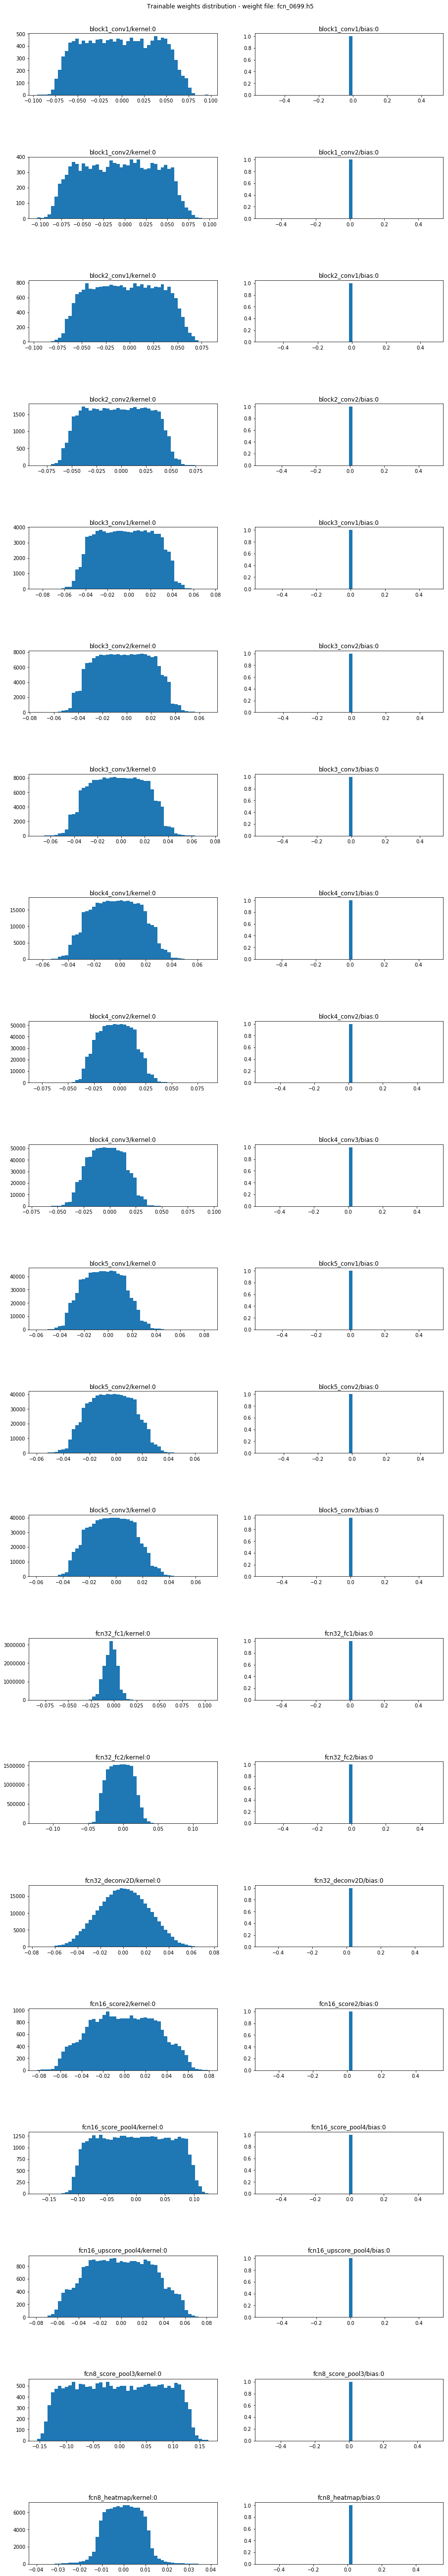

In [36]:
a = visualize.display_weight_histograms(fcn_model, filename = files[6])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[6]+'.png')
a.savefig(weights_histogram)